In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyBigWig as bw
import os

Cry1
Cry2
Nr1d1
Nr1d2
Per1
Per2
Per3
Ciart
Clock
Arntl
Npas2
Dbp
Tef
Hlf
Nfil3
Bhlhe40
Fbxl3
Csnk1e
Rora
Rorb
Rorc
Gnai2


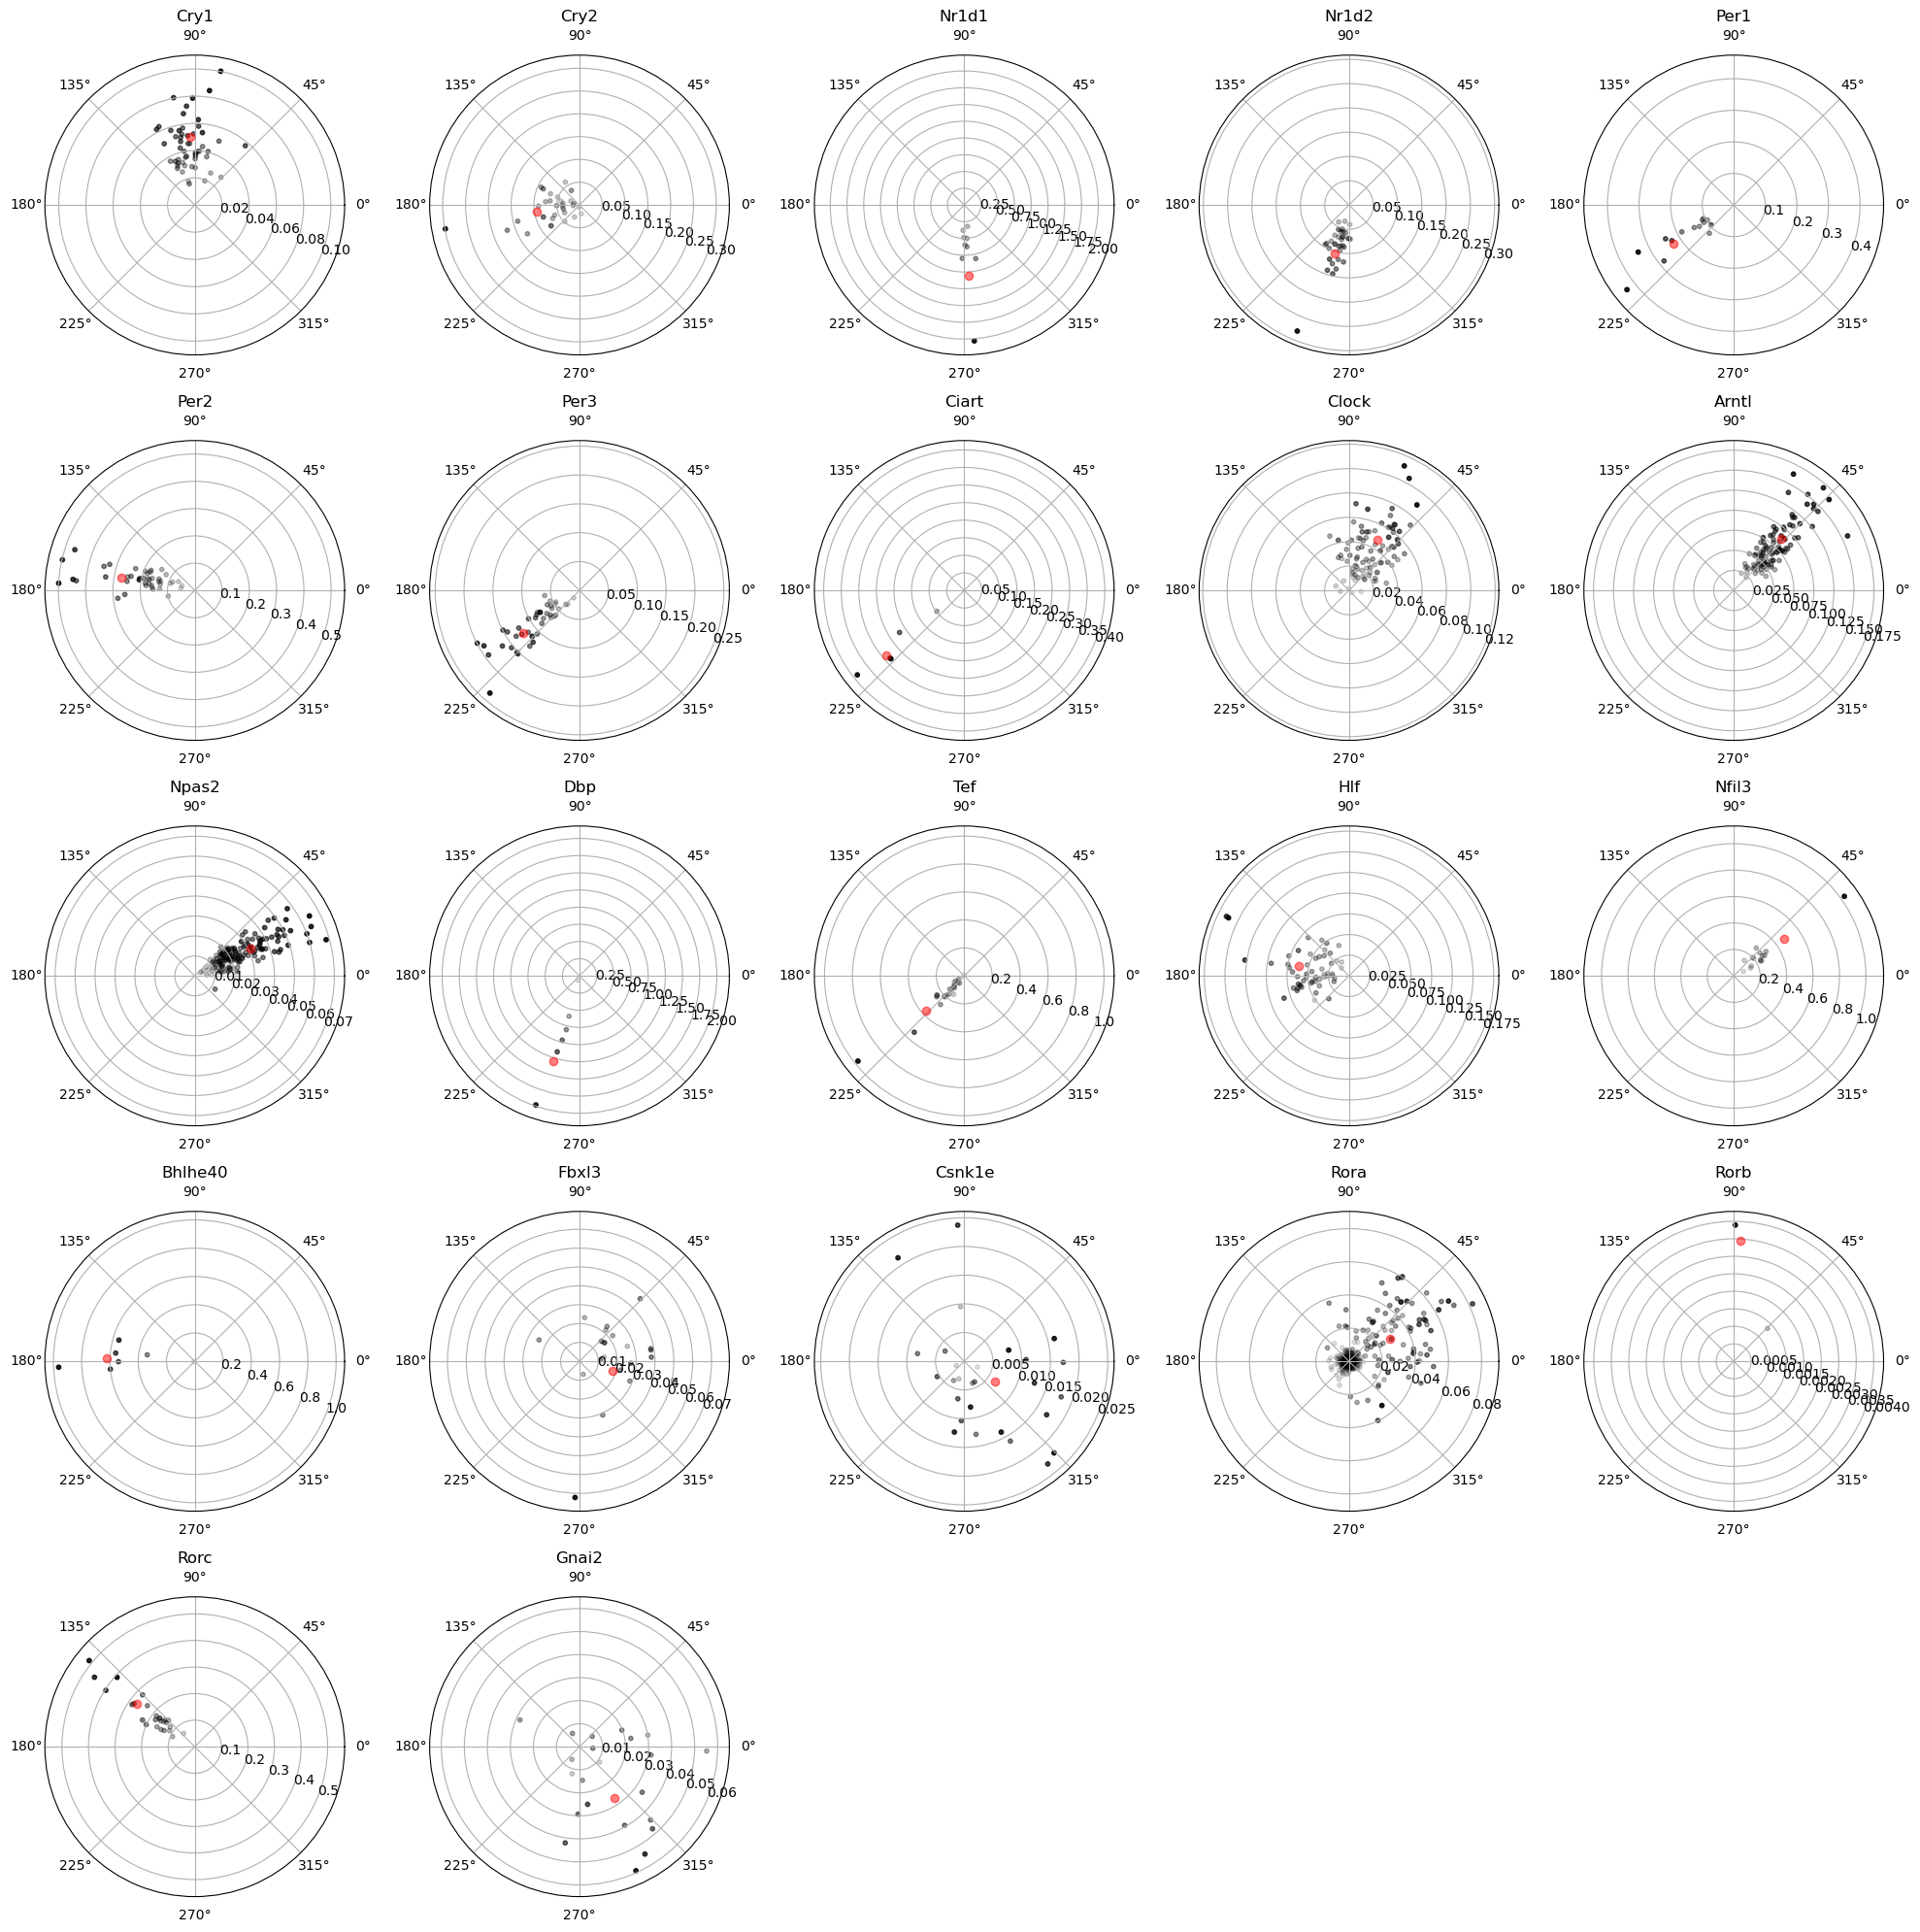

In [39]:
data_folder='../results/binned_norm_counts/'
Samples = [f'PRO_SEQ_CT{4*i:02d}_S{i+1}_R1_001' for i in range(12)]
Strands = ['forward','reverse']
bin_size = 1000
T = np.arange(0,48,4)

# awk '$3=="gene"' resources/genome/GRCm39/gencode.vM33.primary_assembly.annotation.gtf | grep "^chr" > resources/genome/GRCm39/gene.gtf
gtf = pd.read_csv('../resources/genome/GRCm39/gene.gtf',sep='\t',header=None)
gtf.columns = ['chr','source','type','start','end','score','strand','frame','attribute']
gtf['gene_name'] = gtf.attribute.str.extract(r'gene_name "(.*?)";')

f = {}
for sample in Samples:
    t = int(sample.split('_')[2][2:])
    f[t] = {}
    for strand in Strands:
        if strand=='forward':
            f[t]['+'] = bw.open(f"{data_folder}/{sample}/NormCoverage_3p_{strand}_bin{bin_size}bp.bw")
        elif strand=='reverse':
            f[t]['-'] = bw.open(f"{data_folder}/{sample}/NormCoverage_3p_{strand}_bin{bin_size}bp.bw")

Genes = ["Cry1","Cry2","Nr1d1","Nr1d2","Per1","Per2","Per3","Ciart","Clock","Arntl","Npas2","Dbp","Tef","Hlf","Nfil3","Bhlhe40","Fbxl3","Csnk1e","Rora","Rorb","Rorc","Gnai2"]
n_col = int(np.ceil(np.sqrt(len(Genes))))
n_row = int(np.ceil(len(Genes)/n_col))
fig = plt.figure(figsize=(n_col*4,n_row*4))
for g, gene in enumerate(Genes):
    print(gene)

    coord = gtf.loc[gtf.gene_name==gene,['chr','start','end','strand']]
    chr = coord.chr.values[0]
    start = coord.start.values[0]
    end = coord.end.values[0]
    strand = coord.strand.values[0]

    Bins = np.arange(start - start%bin_size,end + bin_size - end%bin_size,bin_size)

    X = np.zeros((len(Bins),len(T)))
    X[:] = np.nan
    df = pd.DataFrame(X,index=Bins,columns=T)

    for t in T:
        vals = f[t][strand].intervals(chr,start,end)
        if vals is None:
            df.loc[:,t] = np.nan
            continue

        bins = [vals[i][0] for i in range(len(vals))]
        counts = [vals[i][2] for i in range(len(vals))]
        df.loc[bins,t] = counts

    idx_out = np.isnan(df.values).sum(1) > .8*T.shape[0]
    df = df.loc[~idx_out,:]
    df[np.isnan(df.values)] = 0

    X = df.values
    w = X.sum(1)
    w = w/w.sum()
    alpha = 0.8*(w/np.max(w)) + .1

    # fourier transform
    for n in range(1,2):
        f_n = np.sum(X*np.exp(-1j*2*n*np.pi*T/24),1)
        a_n = np.abs(f_n)
        phi_n = np.angle(f_n)

        f_m = np.sum(f_n*w)
        a = np.abs(f_m)
        phi = np.angle(f_m)

    # plot in polar coordinates
    ax = fig.add_subplot(n_row,n_col,g+1,projection='polar')
    ax.scatter(phi_n,a_n,s=10,marker='o',c='k',alpha=alpha)
    ax.plot(phi,a,'o',color='r',alpha=0.5)
    ax.set_rmax(1.1*np.max(a_n))
    #ax.set_rticks([0.25, 0.5])  # less radial ticks
    ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
    ax.grid(True)
    ax.set_title(gene)

plt.tight_layout()



In [37]:
.8*T.shape[0]

9.600000000000001